<a href="https://colab.research.google.com/github/dakoyaki/data-imputation/blob/main/Imputation_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Dataset

## About data set

### Speed data

This data set is created by [Uber Movement](https://movement.uber.com/) project, which includes the average speed on a given road segment for each hour of each day in April 2019 in Berlin, Germany. 

## Load data

### Data behavior
There are some data behaviors/characteristics associated with mobile sensing:

*   Extremely high-dimensional

There are massive amount of road segments with different directions, and which also implies high spatial resolution. Even though this data set is massive, it is far from complete because of sufficient sampling:

*   High-resolution road segmentation
*   The data set only includes road segments with at least 5 unique trips in that hour

In [ ]:
import pandas as pd

data = pd.read_csv('/content/drive/MyDrive/Traffic speed imputation/Data/berlin-speeds-apr-2019.csv')
## Convert utc_timestamp to a datetime field 'timestamp'
data['timestamp'] = pd.to_datetime(data.utc_timestamp)

data.head()

,year,month,day,hour,utc_timestamp,segment_id,start_junction_id,end_junction_id,osm_way_id,osm_start_node_id,osm_end_node_id,speed_kph_mean,speed_kph_stddev,timestamp
0,2019,4,1,18,2019-04-01T16:00:00.000Z,f50b8a5ca0afcdd31eb48403172284dbc42f2aeb,dc072f474bcbf30d75bd3b1e42974396af504bbb,32c9d31816ecf0fde2586bab37995d06ad5f6f3e,30709742,235637275,235637281,33.726,5.425,2019-04-01 16:00:00+00:00
1,2019,4,1,14,2019-04-01T12:00:00.000Z,f50b8a5ca0afcdd31eb48403172284dbc42f2aeb,dc072f474bcbf30d75bd3b1e42974396af504bbb,32c9d31816ecf0fde2586bab37995d06ad5f6f3e,30709742,235637275,235637281,27.223,3.984,2019-04-01 12:00:00+00:00
2,2019,4,10,18,2019-04-10T16:00:00.000Z,f50b8a5ca0afcdd31eb48403172284dbc42f2aeb,dc072f474bcbf30d75bd3b1e42974396af504bbb,32c9d31816ecf0fde2586bab37995d06ad5f6f3e,30709742,235637275,235637281,31.192,6.514,2019-04-10 16:00:00+00:00
3,2019,4,1,20,2019-04-01T18:00:00.000Z,f50b8a5ca0afcdd31eb48403172284dbc42f2aeb,dc072f474bcbf30d75bd3b1e42974396af504bbb,32c9d31816ecf0fde2586bab37995d06ad5f6f3e,30709742,235637275,235637281,36.729,6.949,2019-04-01 18:00:00+00:00
4,2019,4,1,16,2019-04-01T14:00:00.000Z,f50b8a5ca0afcdd31eb48403172284dbc42f2aeb,dc072f474bcbf30d75bd3b1e42974396af504bbb,32c9d31816ecf0fde2586bab37995d06ad5f6f3e,30709742,235637275,235637281,33.393,13.653,2019-04-01 14:00:00+00:00


## View data

In [ ]:
data.count()

year                 1897023
month                1897023
day                  1897023
hour                 1897023
utc_timestamp        1897023
segment_id           1897023
start_junction_id    1897023
end_junction_id      1897023
osm_way_id           1897023
osm_start_node_id    1897023
osm_end_node_id      1897023
speed_kph_mean       1897023
speed_kph_stddev     1897023
timestamp            1897023
dtype: int64

In [ ]:
ts_data = data.copy()

ts_data.set_index('timestamp',inplace=True)

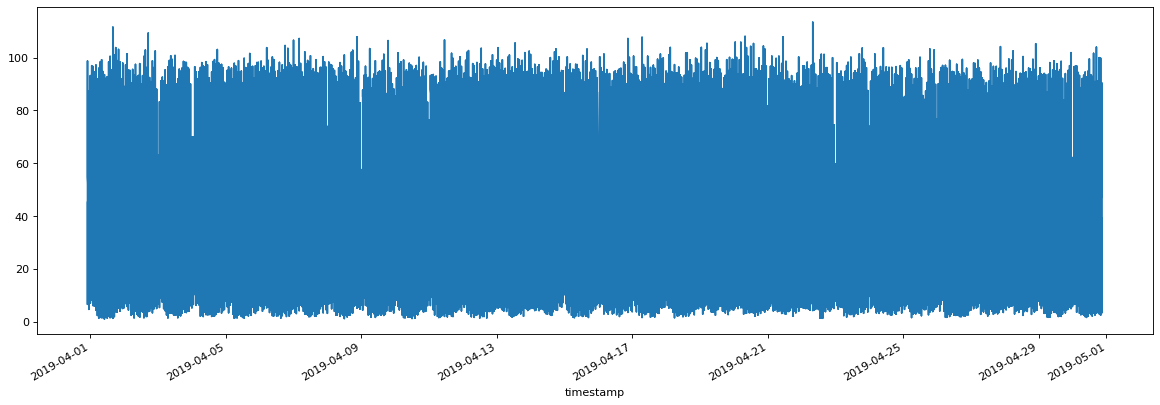

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(18, 6), dpi=80)
ts_data['speed_kph_mean'].plot()

A LOT of data is here. I'll get a grouping by hour to clean it up. 

In [ ]:
ts_data = data.resample('H', on='timestamp').agg({'speed_kph_mean':'mean'})
ts_data.head()

,speed_kph_mean
timestamp,
2019-03-31 22:00:00+00:00,44.740801
2019-03-31 23:00:00+00:00,43.350231
2019-04-01 00:00:00+00:00,45.635742
2019-04-01 01:00:00+00:00,48.136917
2019-04-01 02:00:00+00:00,48.014715


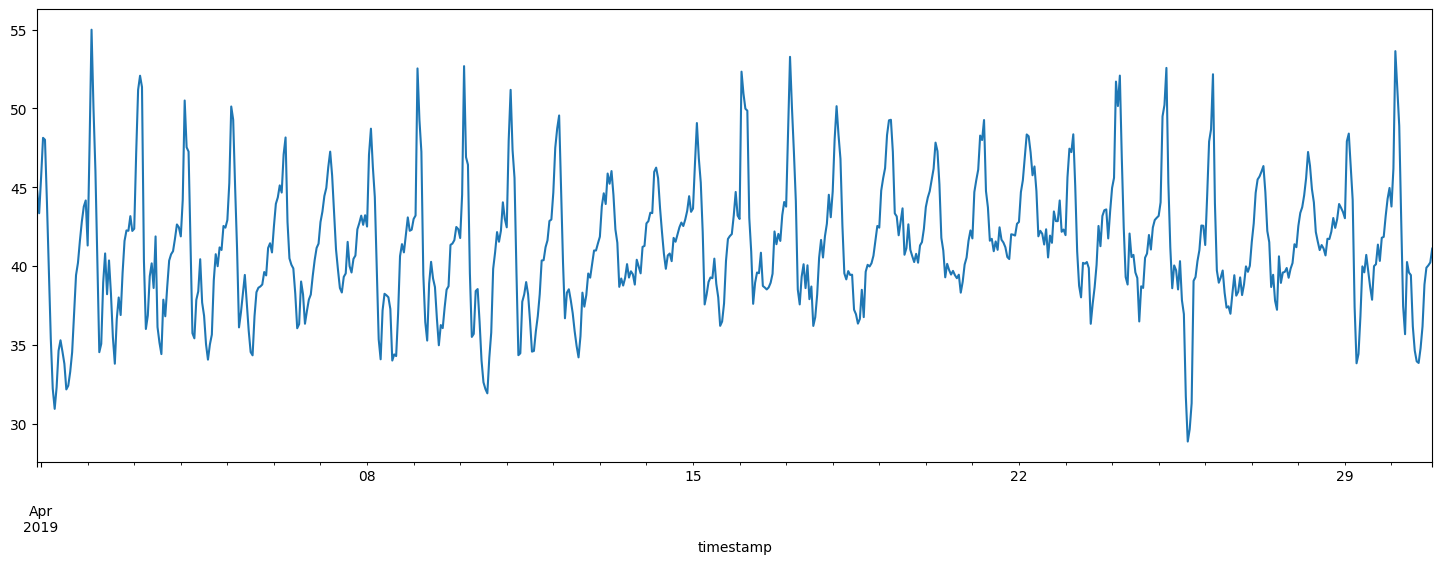

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(18, 6), dpi=100)
ts_data['speed_kph_mean'].plot()

 I wanted to make a heatmap for this data to see the average speeds by hour by day.

In [ ]:
ts_data_heatmap_mean = data.groupby(['day','hour']).agg({'speed_kph_mean':'mean'}).unstack()
ts_data_heatmap_max = data.groupby(['day','hour']).agg({'speed_kph_mean':'max'}).unstack()
ts_data_heatmap_min = data.groupby(['day','hour']).agg({'speed_kph_mean':'min'}).unstack()

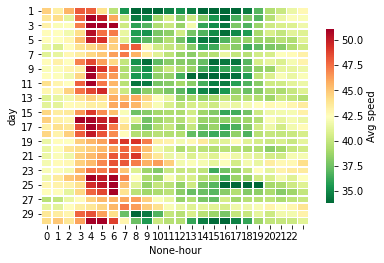

In [ ]:
import seaborn as sns

ax = sns.heatmap(ts_data_heatmap_mean, cmap='RdYlGn_r', robust=True, fmt='.2f', 
                 annot=False, linewidths=.5, annot_kws={'size':11}, 
                 cbar_kws={'shrink':.8, 'label':'Avg speed'})                       

ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
ax.set_xticklabels(range(23), rotation=0, fontsize=10)
plt.title('', fontdict={'fontsize':15}, pad=20);
sns.set(rc={'figure.figsize':(10,10)})


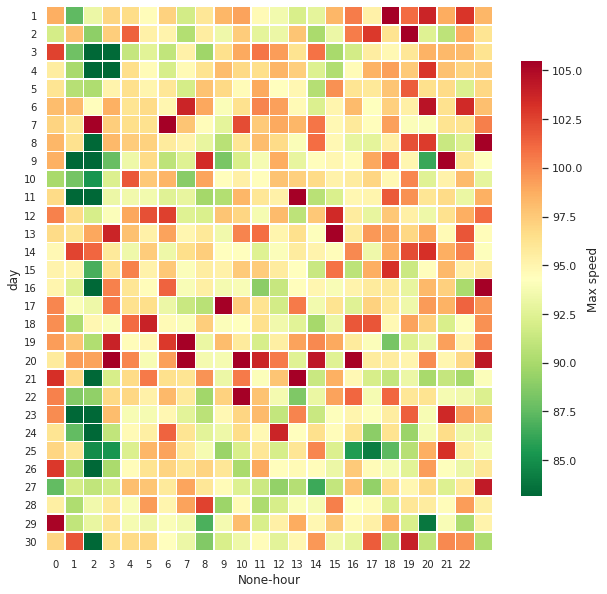

In [ ]:
import seaborn as sns

ax = sns.heatmap(ts_data_heatmap_max, cmap='RdYlGn_r', robust=True, fmt='.2f', 
                 annot=False, linewidths=.5, annot_kws={'size':11}, 
                 cbar_kws={'shrink':.8, 'label':'Max speed'})                       

ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
ax.set_xticklabels(range(23), rotation=0, fontsize=10)
plt.title('', fontdict={'fontsize':15}, pad=20);
sns.set(rc={'figure.figsize':(10,10)})


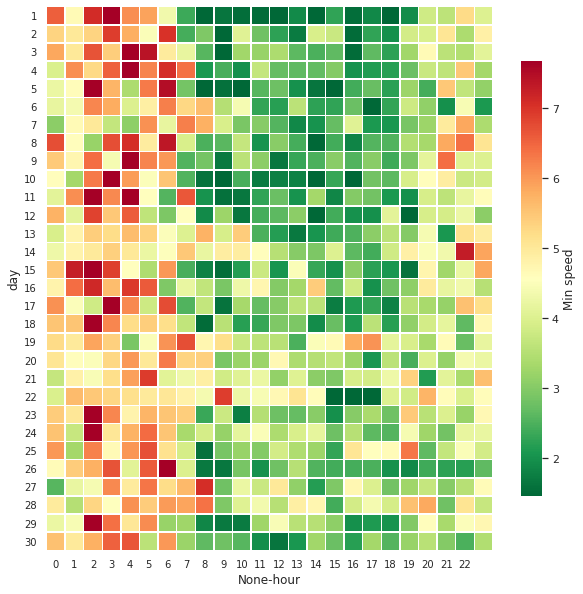

In [ ]:
import seaborn as sns

ax = sns.heatmap(ts_data_heatmap_min, cmap='RdYlGn_r', robust=True, fmt='.2f', 
                 annot=False, linewidths=.5, annot_kws={'size':11}, 
                 cbar_kws={'shrink':.8, 'label':'Min speed'})                       

ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
ax.set_xticklabels(range(23), rotation=0, fontsize=10)
plt.title('', fontdict={'fontsize':15}, pad=20);
sns.set(rc={'figure.figsize':(10,10)})


There are trends, which is good.

For the models, I wanted to clean the data as little as possible. I've been reading up on "live" data processing and the chance to clean that data is limited to none, so I took that approach here.

## Build Tensor .npy

But before building the models, I did need to convert the data into a matrix

In [ ]:
import numpy as np
import pandas as pd

road = data.drop_duplicates(['osm_way_id', 'osm_start_node_id', 'osm_end_node_id']) ## Drop any duplicates
road = road.drop(['year', 'month', 'day', 'hour', 'utc_timestamp', 'segment_id', 'start_junction_id', 
                  'end_junction_id', 'speed_kph_mean', 'speed_kph_stddev'], axis = 1) ## Get just the roads

print('Number of road segments: {}'.format(road.shape[0]))

## Build tensor, 
### road count / max number of days / 24 hours
tensor = np.zeros((road.shape[0], max(data.day.values), 24))

k = 0
for i in range(road.shape[0]):
    temp = data[(data['osm_way_id'] == road.osm_way_id.iloc[i]) 
                & (data['osm_start_node_id'] == road.osm_start_node_id.iloc[i]) 
                & (data['osm_end_node_id'] == road.osm_end_node_id.iloc[i])]
    for j in range(temp.shape[0]):
        tensor[k, temp.day.iloc[j] - 1, temp.hour.iloc[j]] = temp.speed_kph_mean.iloc[j]
    k += 1
    ## Print the progress
    if (k % 1000) == 0:
      print('{}% processed'.format(round((k/road.shape[0])*100),2))

## Build tensor mat
mat = tensor.reshape([road.shape[0], max(data.day.values) * 24])

## Save as numpy file
np.save('/content/drive/MyDrive/Traffic speed imputation/Data/Speed/hourly_speed_mat.npy', mat)

## Delete unneeded data
del data, road, tensor

Number of road segments: 18624
5% processed
11% processed
16% processed
21% processed
27% processed
32% processed
38% processed
43% processed
48% processed
54% processed
59% processed
64% processed
70% processed
75% processed
81% processed
86% processed
91% processed
97% processed


# Models for imputations

After some indepth literature reviews, I settled on these three main models (which all perfomed about the same...).

The format for the three following model specific sections is the same:
1. Model introduction & literature
2. Defining functions
3. Defining the model
4. Running the model

Each of the models have multiple variations and each of those has a plot to show the real vs estimated values. I did not clean the plots for each of them and instead took the best models and ran them again with cleaner visualisations in the "Model results" section. 

## Bayesian Augmented Tensor Factorization

Source: 
<div class="alert alert-block alert-info">
<font color="black">
Xinyu Chen, Zhaocheng He, Yixian Chen, Yuhuan Lu, Jiawei Wang (2019). <b>Missing traffic data imputation and pattern discovery with a Bayesian augmented tensor factorization model</b>. Transportation Research Part C: Emerging Technologies, 104: 66-77. <a href="https://doi.org/10.1016/j.trc.2019.03.003" title="PDF"><b>[PDF]</b></a> 
</font>
</div>

Abstract:

Spatiotemporal traffic data, which represent multidimensional time series on considering different spatial locations, are ubiquitous in real-world transportation systems. However, the inevitable missing data problem makes data-driven intelligent transportation systems suffer from an incorrect response. Therefore, imputing missing values is of great importance but challenging as it is not easy to capture spatiotemporal traffic patterns, including explicit and latent features. In this study, we propose an augmented tensor factorization model by incorporating generic forms of domain knowledge from transportation systems. Specifically, we present a fully Bayesian framework for automatically learning parameters of this model using variational Bayes (VB). Relying on the publicly available urban traffic speed data set collected in Guangzhou, China, experiments on two types of missing data scenarios (i.e., random and non-random) demonstrate that the proposed Bayesian augmented tensor factorization (BATF) model achieves best imputation accuracies and outperforms the state-of-the-art baselines (e.g., Bayesian tensor factorization models). Besides, we discover interpretable patterns from the experimentally learned global parameter, biases, and latent factors that indeed conform to the dynamic of traffic states.

### Define functions

In [ ]:
import numpy as np
from numpy.random import multivariate_normal as mvnrnd
from scipy.stats import wishart
from numpy.random import normal as normrnd
from numpy.linalg import inv as inv
from numpy.linalg import solve as solve
from numpy.linalg import cholesky as cholesky_lower
from scipy.linalg import cholesky as cholesky_upper
from scipy.linalg import solve_triangular as solve_ut
from scipy.linalg import solve_triangular as solve_ut
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def kr_prod(a, b):
    return np.einsum('ir, jr -> ijr', a, b).reshape(a.shape[0] * b.shape[0], -1)

In [ ]:
def mvnrnd_pre(mu, Lambda):
    src = normrnd(size = (mu.shape[0],))
    return solve_ut(cholesky_upper(Lambda, overwrite_a = True, check_finite = False), 
                    src, lower = False, check_finite = False, overwrite_b = True) + mu

In [ ]:
def cp_combine(var):
    return np.einsum('is, js, ts -> ijt', var[0], var[1], var[2])

In [ ]:
## 1st solution
def vec_combine(vector):
    tensor = 0
    d = len(vector)
    for i in range(d):
        ax = [len(vector[i]) if j == i else 1 for j in range(d)]
        tensor = tensor + vector[i].reshape(ax, order = 'F')
    return tensor

## 2nd solution
def vec_combine(vector):
    return (vector[0][:, np.newaxis, np.newaxis] + vector[1][np.newaxis, :, np.newaxis]
            + vector[2][np.newaxis, np.newaxis, :])

In [ ]:
def ten2mat(tensor, mode):
    return np.reshape(np.moveaxis(tensor, mode, 0), (tensor.shape[mode], -1), order = 'F')

In [ ]:
def mat2ten(mat, dim, mode):
    index = list()
    index.append(mode)
    for i in range(dim.shape[0]):
        if i != mode:
            index.append(i)
    return np.moveaxis(np.reshape(mat, list(dim[index]), order = 'F'), 0, mode)

In [ ]:
def cov_mat(mat, mat_bar):
    mat = mat - mat_bar
    return mat.T @ mat

In [ ]:
def compute_mape(var, var_hat):
    return np.sum(np.abs(var - var_hat) / var) / var.shape[0]

def compute_rmse(var, var_hat):
    return  np.sqrt(np.sum((var - var_hat) ** 2) / var.shape[0])

In [ ]:
def sample_global_mu(mu_sparse, pos_obs, tau_eps, tau0 = 1):
    tau_tilde = 1 / (tau_eps * len(pos_obs[0]) + tau0)
    mu_tilde = tau_eps * np.sum(mu_sparse) * tau_tilde
    return np.random.normal(mu_tilde, np.sqrt(tau_tilde))

In [ ]:
def sample_bias_vector(bias_sparse, factor, bias, ind, dim, k, tau_eps, tau0 = 1):
    for k in range(len(dim)):
        idx = tuple(filter(lambda x: x != k, range(len(dim))))
        temp = vector.copy()
        temp[k] = np.zeros((dim[k]))
        tau_tilde = 1 / (tau_eps * bias[k] + tau0)
        mu_tilde = tau_eps * np.sum(ind * (bias_sparse - vec_combine(temp)), axis = idx) * tau_tilde
        vector[k] = np.random.normal(mu_tilde, np.sqrt(tau_tilde))
    return vector

In [ ]:
def sample_factor(tau_sparse, factor, ind, dim, k, tau_eps, beta0 = 1):
    dim, rank = factor[k].shape
    dim = factor[k].shape[0]
    factor_bar = np.mean(factor[k], axis = 0)
    temp = dim / (dim + beta0)
    var_mu_hyper = temp * factor_bar
    var_W_hyper = inv(np.eye(rank) + cov_mat(factor[k], factor_bar) + temp * beta0 * np.outer(factor_bar, factor_bar))
    var_Lambda_hyper = wishart.rvs(df = dim + rank, scale = var_W_hyper)
    var_mu_hyper = mvnrnd_pre(var_mu_hyper, (dim + beta0) * var_Lambda_hyper)
    
    idx = list(filter(lambda x: x != k, range(len(factor))))
    var1 = kr_prod(factor[idx[1]], factor[idx[0]]).T
    var2 = kr_prod(var1, var1)
    var3 = (var2 @ ten2mat(tau_eps * ind, k).T).reshape([rank, rank, dim]) + var_Lambda_hyper[:, :, np.newaxis]
    var4 = var1 @ ten2mat(tau_sparse, k).T + (var_Lambda_hyper @ var_mu_hyper)[:, np.newaxis]
    for i in range(dim):
        factor[k][i, :] = mvnrnd_pre(solve(var3[:, :, i], var4[:, i]), var3[:, :, i])
    return factor[k]

In [ ]:
def sample_precision_tau(error_tensor, pos_obs):
    var_alpha = 1e-6 + 0.5 * len(pos_obs[0])
    var_beta = 1e-6 + 0.5 * np.linalg.norm(error_tensor, 2) ** 2
    return np.random.gamma(var_alpha, 1 / var_beta)

In [ ]:
def mvnrnd_pre(mu, Lambda):
    src = normrnd(size = (mu.shape[0],))
    return solve_ut(cholesky_upper(Lambda, overwrite_a = True, check_finite = False), 
                    src, lower = False, check_finite = False, overwrite_b = True) + mu

### BATF implementation - function

In [ ]:
def BATF_Gibbs(dense_tensor, sparse_tensor, vector, factor, burn_iter, gibbs_iter):
    """Bayesian Augmented Tensor Factorization (BATF) with Gibbs sampling."""

    dim = np.array(sparse_tensor.shape)
    rank = factor[0].shape[1]
    if np.isnan(sparse_tensor).any() == False:
        ind = sparse_tensor != 0
        pos_obs = np.where(ind)
        pos_test = np.where((dense_tensor != 0) & (sparse_tensor == 0))
    elif np.isnan(sparse_tensor).any() == True:
        pos_test = np.where((dense_tensor != 0) & (np.isnan(sparse_tensor)))
        ind = ~np.isnan(sparse_tensor)
        pos_obs = np.where(ind)
        sparse_tensor[np.isnan(sparse_tensor)] = 0
    num_obs = len(pos_obs[0])
    dense_test = dense_tensor[pos_test]
    del dense_tensor

    show_iter = 200
    tau_eps = 1
    bias = []
    for k in range(len(dim)):
        idx = tuple(filter(lambda x: x != k, range(len(dim))))
        bias.append(np.sum(ind, axis = idx))
    temp = cp_combine(factor)
    temp_hat = np.zeros(len(pos_test[0]))
    tensor_hat_plus = np.zeros(dim)
    for it in range(burn_iter + gibbs_iter):
        temp = sparse_tensor - temp
        mu_glb = sample_global_mu(temp[pos_obs] - vec_combine(vector)[pos_obs], pos_obs, tau_eps)
        vector = sample_bias_vector(temp - mu_glb, factor, bias, ind, dim, k, tau_eps)
        del temp
        tau_sparse = tau_eps * ind * (sparse_tensor - mu_glb - vec_combine(vector))
        for k in range(len(dim)):
            factor[k] = sample_factor(tau_sparse, factor, ind, dim, k, tau_eps)
        temp = cp_combine(factor)
        tensor_hat = mu_glb + vec_combine(vector) + temp
        temp_hat += tensor_hat[pos_test]
        tau_eps = sample_precision_tau(sparse_tensor[pos_obs] - tensor_hat[pos_obs], pos_obs)
        if it + 1 > burn_iter:
            tensor_hat_plus += tensor_hat
        if (it + 1) % show_iter == 0 and it < burn_iter:
            temp_hat = temp_hat / show_iter
            print('Iter: {}'.format(it + 1))
            print('MAPE: {:.6}'.format(compute_mape(dense_test, temp_hat)))
            print('RMSE: {:.6}'.format(compute_rmse(dense_test, temp_hat)))
            temp_hat = np.zeros(len(pos_test[0]))
            print()
    tensor_hat = tensor_hat_plus / gibbs_iter
    print('Imputation MAPE: {:.6}'.format(compute_mape(dense_test, tensor_hat[pos_test])))
    print('Imputation RMSE: {:.6}'.format(compute_rmse(dense_test, tensor_hat[pos_test])))
    print()

    return tensor_hat, mu_glb, vector, factor, dense_test, pos_test

### Running on Berlin data


#### Model 1

Random 30% of data missing

In [ ]:
import numpy as np
np.random.seed(1000)

missing_rate = 0.3

dense_mat = np.load('/content/drive/MyDrive/Traffic speed imputation/Data/Speed/hourly_speed_mat.npy')
binary_mat = dense_mat.copy()
binary_mat[binary_mat != 0] = 1
pos = np.where(np.sum(binary_mat, axis = 1) > 0.7 * binary_mat.shape[1])
dense_mat = dense_mat[pos[0], :]
dim1, dim2 = dense_mat.shape
del binary_mat

## Random missing (RM)
sparse_mat = dense_mat * np.round(np.random.rand(dim1, dim2) + 0.5 - missing_rate)
dense_tensor = dense_mat.reshape([dim1, 30, 24]).transpose(0, 2, 1)
sparse_tensor = sparse_mat.reshape([dim1, 30, 24]).transpose(0, 2, 1)
del dense_mat, sparse_mat

In [ ]:
import time
start = time.time()
dim = np.array(sparse_tensor.shape)
rank = 20
vector = []
factor = []
for k in range(len(dim)):
    vector.append(0.1 * np.random.randn(dim[k],))
    factor.append(0.1 * np.random.randn(dim[k], rank))
burn_iter = 1000
gibbs_iter = 200
tensor_hat, mu_glb, vector, factor, dense_test, pos_test = BATF_Gibbs(dense_tensor, sparse_tensor, vector, factor, burn_iter, gibbs_iter)
end = time.time()
print('Running time: %d seconds'%(end - start))

Iter: 200
MAPE: 0.100867
RMSE: 4.7017

Iter: 400
MAPE: 0.100632
RMSE: 4.69522

Iter: 600
MAPE: 0.100617
RMSE: 4.69342

Iter: 800
MAPE: 0.100613
RMSE: 4.69414

Iter: 1000
MAPE: 0.100579
RMSE: 4.69319

Imputation MAPE: 0.100577
Imputation RMSE: 4.69237

Running time: 532 seconds


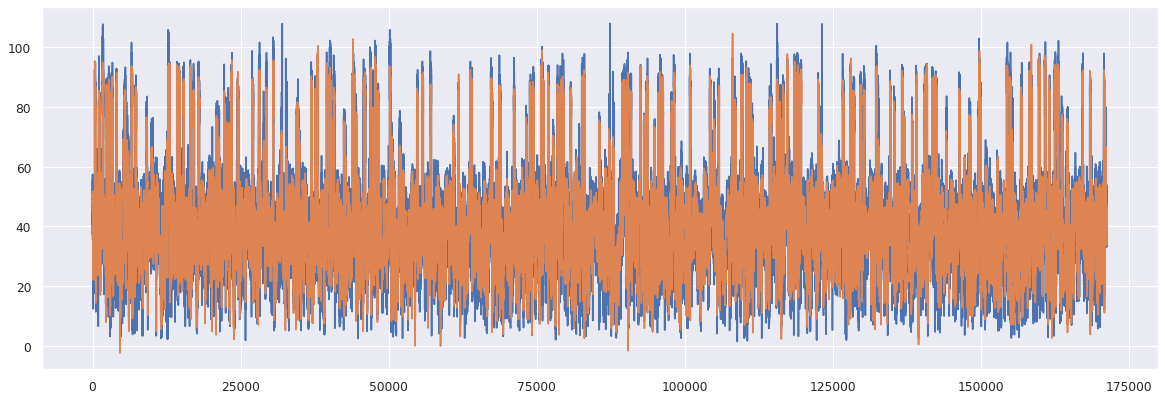

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(18, 6), dpi=80)

plt.plot(dense_test)
plt.plot(tensor_hat[pos_test]) 

#### Model 2

Random 70% of data missing

In [ ]:
import numpy as np
np.random.seed(1000)

missing_rate = 0.7

dense_mat = np.load('/content/drive/MyDrive/Traffic speed imputation/Data/Speed/hourly_speed_mat.npy')
binary_mat = dense_mat.copy()
binary_mat[binary_mat != 0] = 1
pos = np.where(np.sum(binary_mat, axis = 1) > 0.7 * binary_mat.shape[1])
dense_mat = dense_mat[pos[0], :]
dim1, dim2 = dense_mat.shape
del binary_mat

## Random missing (RM)
sparse_mat = dense_mat * np.round(np.random.rand(dim1, dim2) + 0.5 - missing_rate)
dense_tensor = dense_mat.reshape([dim1, 30, 24]).transpose(0, 2, 1)
sparse_tensor = sparse_mat.reshape([dim1, 30, 24]).transpose(0, 2, 1)
del dense_mat, sparse_mat

In [ ]:
import time
start = time.time()
dim = np.array(sparse_tensor.shape)
rank = 20
vector = []
factor = []
for k in range(len(dim)):
    vector.append(0.1 * np.random.randn(dim[k],))
    factor.append(0.1 * np.random.randn(dim[k], rank))
burn_iter = 1000
gibbs_iter = 200
tensor_hat, mu_glb, vector, factor, dense_test, pos_test = BATF_Gibbs(dense_tensor, sparse_tensor, vector, factor, burn_iter, gibbs_iter)
end = time.time()
print('Running time: %d seconds'%(end - start))

Iter: 200
MAPE: 0.104288
RMSE: 4.86615

Iter: 400
MAPE: 0.104164
RMSE: 4.87611

Iter: 600
MAPE: 0.104133
RMSE: 4.86708

Iter: 800
MAPE: 0.104195
RMSE: 4.86778

Iter: 1000
MAPE: 0.104162
RMSE: 4.86724

Imputation MAPE: 0.104189
Imputation RMSE: 4.86817

Running time: 530 seconds


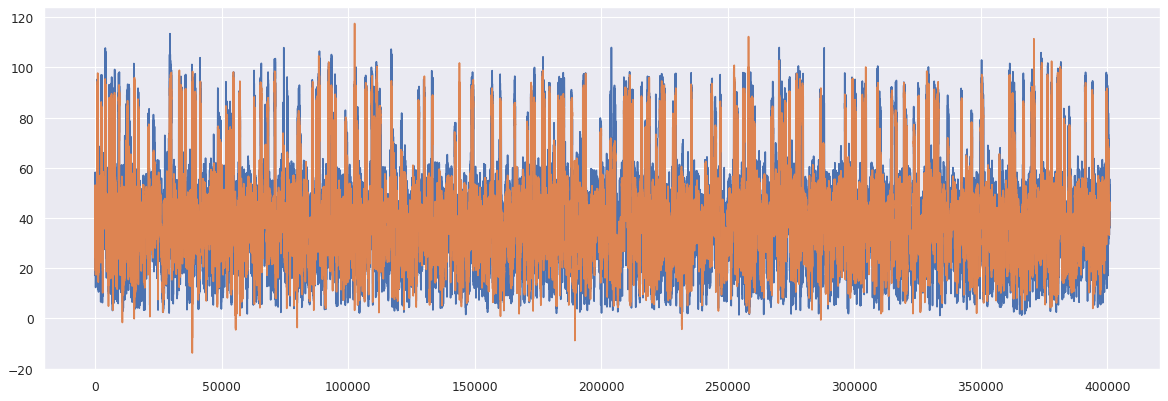

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(18, 6), dpi=80)

plt.plot(dense_test)
plt.plot(tensor_hat[pos_test]) 

#### Model 3

Random 30% of data missing

In [ ]:
import numpy as np
np.random.seed(1000)

missing_rate = 0.3

dense_mat = np.load('/content/drive/MyDrive/Traffic speed imputation/Data/Speed/hourly_speed_mat.npy')
binary_mat = dense_mat.copy()
binary_mat[binary_mat != 0] = 1
pos = np.where(np.sum(binary_mat, axis = 1) > 0.7 * binary_mat.shape[1])
dense_mat = dense_mat[pos[0], :]
dim1, dim2 = dense_mat.shape
del binary_mat

## Non-random missing (NM)
dense_tensor = dense_mat.reshape([dim1, 30, 24]).transpose(0, 2, 1)
sparse_tensor = dense_tensor * np.round(np.random.rand(dim1, 30) + 0.5 - missing_rate)[:, None, :]
del dense_mat

In [ ]:
import time
start = time.time()
dim = np.array(sparse_tensor.shape)
rank = 20
vector = []
factor = []
for k in range(len(dim)):
    vector.append(0.1 * np.random.randn(dim[k],))
    factor.append(0.1 * np.random.randn(dim[k], rank))
burn_iter = 1000
gibbs_iter = 200
tensor_hat, mu_glb, vector, factor, dense_test, pos_test = BATF_Gibbs(dense_tensor, sparse_tensor, vector, factor, burn_iter, gibbs_iter)
end = time.time()
print('Running time: %d seconds'%(end - start))

Iter: 200
MAPE: 0.107477
RMSE: 4.94704

Iter: 400
MAPE: 0.108122
RMSE: 4.97342

Iter: 600
MAPE: 0.108347
RMSE: 4.98651

Iter: 800
MAPE: 0.108103
RMSE: 4.97932

Iter: 1000
MAPE: 0.10786
RMSE: 4.97046

Imputation MAPE: 0.10758
Imputation RMSE: 4.95755

Running time: 538 seconds


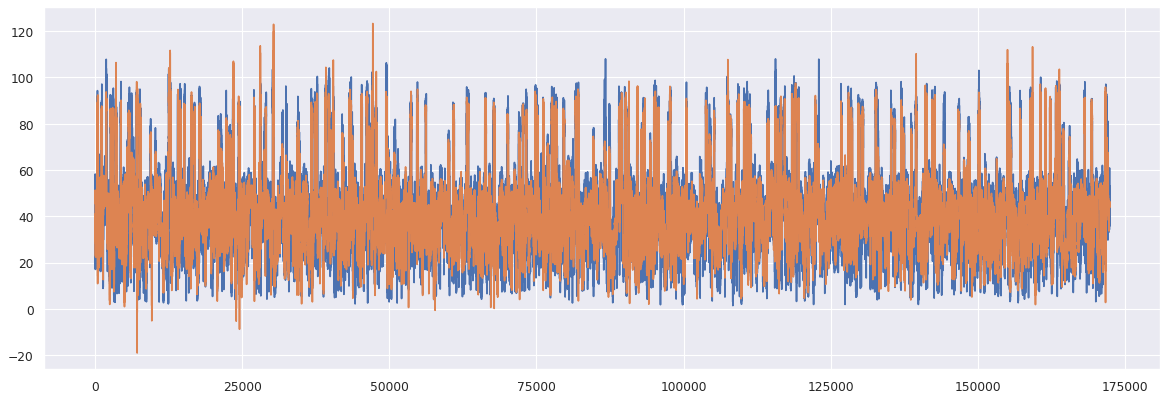

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(18, 6), dpi=80)

plt.plot(dense_test)
plt.plot(tensor_hat[pos_test]) 

#### Model 4

Random 70% of data missing

In [ ]:
import numpy as np
np.random.seed(1000)

missing_rate = 0.7

dense_mat = np.load('/content/drive/MyDrive/Traffic speed imputation/Data/Speed/hourly_speed_mat.npy')
binary_mat = dense_mat.copy()
binary_mat[binary_mat != 0] = 1
pos = np.where(np.sum(binary_mat, axis = 1) > 0.7 * binary_mat.shape[1])
dense_mat = dense_mat[pos[0], :]
dim1, dim2 = dense_mat.shape
del binary_mat

## Non-random missing (NM)
dense_tensor = dense_mat.reshape([dim1, 30, 24]).transpose(0, 2, 1)
sparse_tensor = dense_tensor * np.round(np.random.rand(dim1, 30) + 0.5 - missing_rate)[:, None, :]
del dense_mat

In [ ]:
import time
start = time.time()
dim = np.array(sparse_tensor.shape)
rank = 20
vector = []
factor = []
for k in range(len(dim)):
    vector.append(0.1 * np.random.randn(dim[k],))
    factor.append(0.1 * np.random.randn(dim[k], rank))
burn_iter = 1000
gibbs_iter = 200
tensor_hat, mu_glb, vector, factor, dense_test, pos_test = BATF_Gibbs(dense_tensor, sparse_tensor, vector, factor, burn_iter, gibbs_iter)
end = time.time()
print('Running time: %d seconds'%(end - start))

Iter: 200
MAPE: 0.111282
RMSE: 5.20582

Iter: 400
MAPE: 0.1124
RMSE: 5.28914

Iter: 600
MAPE: 0.11246
RMSE: 5.28732

Iter: 800
MAPE: 0.112357
RMSE: 5.27824

Iter: 1000
MAPE: 0.112182
RMSE: 5.26292

Imputation MAPE: 0.112147
Imputation RMSE: 5.26109

Running time: 520 seconds


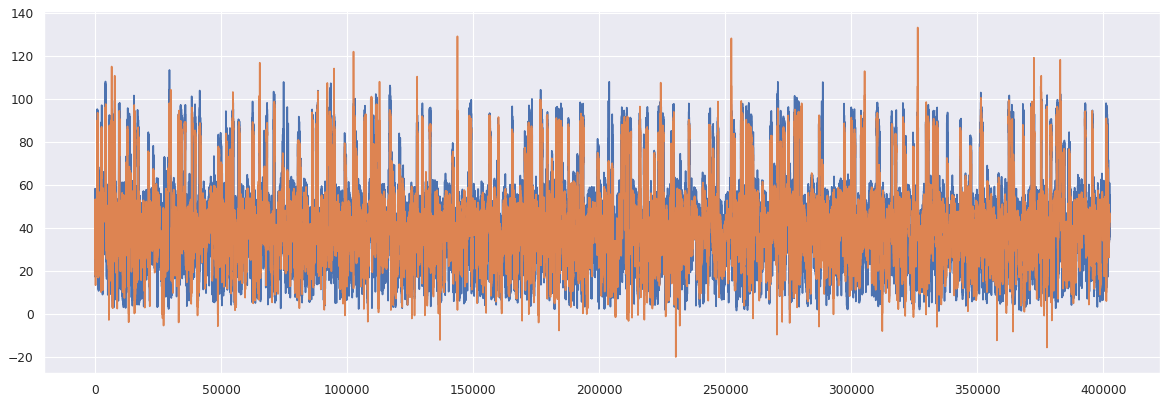

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(18, 6), dpi=80)

plt.plot(dense_test)
plt.plot(tensor_hat[pos_test]) 

#### Model 5

Random 30% of data missing

In [ ]:
import numpy as np
np.random.seed(1000)

missing_rate = 0.3

dense_mat = np.load('/content/drive/MyDrive/Traffic speed imputation/Data/Speed/hourly_speed_mat.npy')
binary_mat = dense_mat.copy()
binary_mat[binary_mat != 0] = 1
pos = np.where(np.sum(binary_mat, axis = 1) > 0.7 * binary_mat.shape[1])
dense_mat = dense_mat[pos[0], :]

## Random missing (RM)
random_mat = np.random.rand(dense_mat.shape[0], dense_mat.shape[1])
binary_mat = np.round(random_mat + 0.5 - missing_rate)
sparse_mat = np.multiply(dense_mat, binary_mat)

dense_tensor = dense_mat.reshape([dense_mat.shape[0], 30, 24])
sparse_tensor = sparse_mat.reshape([sparse_mat.shape[0], 30, 24])
del dense_mat, sparse_mat

In [ ]:
import time
start = time.time()
dim = np.array(sparse_tensor.shape)
rank = 20
vector = []
factor = []
for k in range(len(dim)):
    vector.append(0.1 * np.random.randn(dim[k],))
    factor.append(0.1 * np.random.randn(dim[k], rank))
burn_iter = 1000
gibbs_iter = 200
tensor_hat, mu_glb, vector, factor, dense_test, pos_test = BATF_Gibbs(dense_tensor, sparse_tensor, vector, factor, burn_iter, gibbs_iter)
end = time.time()
print('Running time: %d seconds'%(end - start))

Iter: 200
MAPE: 0.10082
RMSE: 4.69423

Iter: 400
MAPE: 0.100744
RMSE: 4.69693

Iter: 600
MAPE: 0.100603
RMSE: 4.69133

Iter: 800
MAPE: 0.100533
RMSE: 4.69034

Iter: 1000
MAPE: 0.100483
RMSE: 4.68854

Imputation MAPE: 0.100485
Imputation RMSE: 4.68783

Running time: 529 seconds


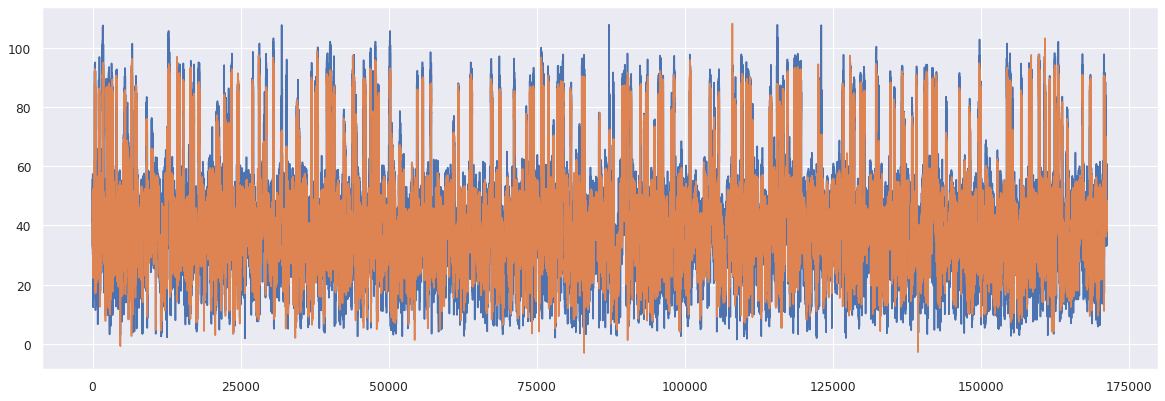

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(18, 6), dpi=80)

plt.plot(dense_test)
plt.plot(tensor_hat[pos_test]) 

#### Model 6

Random 70% of data missing

In [ ]:
import numpy as np
np.random.seed(1000)

missing_rate = 0.7

dense_mat = np.load('/content/drive/MyDrive/Traffic speed imputation/Data/Speed/hourly_speed_mat.npy')
binary_mat = dense_mat.copy()
binary_mat[binary_mat != 0] = 1
pos = np.where(np.sum(binary_mat, axis = 1) > 0.7 * binary_mat.shape[1])
dense_mat = dense_mat[pos[0], :]

## Random missing (RM)
random_mat = np.random.rand(dense_mat.shape[0], dense_mat.shape[1])
binary_mat = np.round(random_mat + 0.5 - missing_rate)
sparse_mat = np.multiply(dense_mat, binary_mat)

dense_tensor = dense_mat.reshape([dense_mat.shape[0], 30, 24])
sparse_tensor = sparse_mat.reshape([sparse_mat.shape[0], 30, 24])
del dense_mat, sparse_mat

In [ ]:
import time
start = time.time()
dim = np.array(sparse_tensor.shape)
rank = 20
vector = []
factor = []
for k in range(len(dim)):
    vector.append(0.1 * np.random.randn(dim[k],))
    factor.append(0.1 * np.random.randn(dim[k], rank))
burn_iter = 1000
gibbs_iter = 200
tensor_hat, mu_glb, vector, factor, dense_test, pos_test = BATF_Gibbs(dense_tensor, sparse_tensor, vector, factor, burn_iter, gibbs_iter)
end = time.time()
print('Running time: %d seconds'%(end - start))

Iter: 200
MAPE: 0.104433
RMSE: 4.86732

Iter: 400
MAPE: 0.104802
RMSE: 4.89324

Iter: 600
MAPE: 0.104775
RMSE: 4.89416

Iter: 800
MAPE: 0.104803
RMSE: 4.89292

Iter: 1000
MAPE: 0.104808
RMSE: 4.89106

Imputation MAPE: 0.104797
Imputation RMSE: 4.88946

Running time: 505 seconds


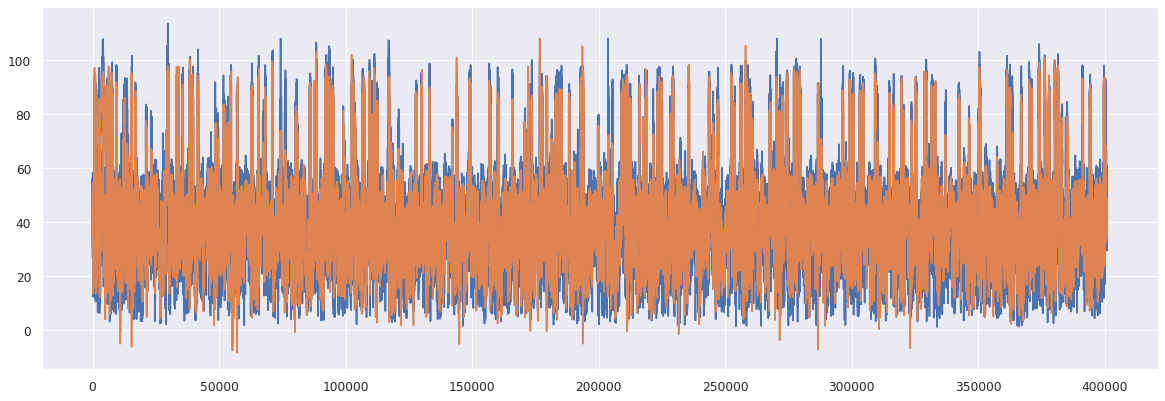

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(18, 6), dpi=80)

plt.plot(dense_test)
plt.plot(tensor_hat[pos_test]) 

## Bayesian Probabilistic Matrix Factorization

Source: 
<div class="alert alert-block alert-info">
<font color="black">
Ruslan Salakhutdinov, Andriy Mnih (2008). <b>Bayesian probabilistic matrix factorization using Markov chain Monte Carlo</b>. ICML 2008. <a href="https://www.cs.toronto.edu/~amnih/papers/bpmf.pdf" title="PDF"><b>[PDF]</b></a> <a href="https://www.cs.toronto.edu/~rsalakhu/BPMF.html" title="Matlab code"><b>[Matlab code]</b></a> 
</font>
</div>

Abstract:

Low-rank matrix approximation methods
provide one of the simplest and most effective
approaches to collaborative filtering. Such
models are usually fitted to data by finding
a MAP estimate of the model parameters, a
procedure that can be performed efficiently
even on very large datasets. However, unless the regularization parameters are tuned
carefully, this approach is prone to overfitting because it finds a single point estimate
of the parameters. In this paper we present a
fully Bayesian treatment of the Probabilistic
Matrix Factorization (PMF) model in which
model capacity is controlled automatically by
integrating over all model parameters and
hyperparameters. We show that Bayesian
PMF models can be efficiently trained using Markov chain Monte Carlo methods by
applying them to the Netflix dataset, which
consists of over 100 million movie ratings.
The resulting models achieve significantly
higher prediction accuracy than PMF models
trained using MAP estimation.

### Define functions

In [ ]:
def mvnrnd_pre(mu, Lambda):
    src = normrnd(size = (mu.shape[0],))
    return solve_ut(cholesky_upper(Lambda, overwrite_a = True, check_finite = False), 
                    src, lower = False, check_finite = False, overwrite_b = True) + mu

def cov_mat(mat, mat_bar):
    mat = mat - mat_bar
    return mat.T @ mat

In [ ]:
def sample_factor_w(tau_sparse_mat, tau_ind, W, X, tau, beta0 = 1, vargin = 0):
    """Sampling N-by-R factor matrix W and its hyperparameters (mu_w, Lambda_w)."""
    
    dim1, rank = W.shape
    W_bar = np.mean(W, axis = 0)
    temp = dim1 / (dim1 + beta0)
    var_mu_hyper = temp * W_bar
    var_W_hyper = inv(np.eye(rank) + cov_mat(W, W_bar) + temp * beta0 * np.outer(W_bar, W_bar))
    var_Lambda_hyper = wishart.rvs(df = dim1 + rank, scale = var_W_hyper)
    var_mu_hyper = mvnrnd_pre(var_mu_hyper, (dim1 + beta0) * var_Lambda_hyper)
    
    if dim1 * rank ** 2 > 1e+8:
        vargin = 1
    
    if vargin == 0:
        var1 = X.T
        var2 = kr_prod(var1, var1)
        var3 = (var2 @ tau_ind.T).reshape([rank, rank, dim1]) + var_Lambda_hyper[:, :, np.newaxis]
        var4 = var1 @ tau_sparse_mat.T + (var_Lambda_hyper @ var_mu_hyper)[:, np.newaxis]
        for i in range(dim1):
            W[i, :] = mvnrnd_pre(solve(var3[:, :, i], var4[:, i]), var3[:, :, i])
    elif vargin == 1:
        for i in range(dim1):
            pos0 = np.where(sparse_mat[i, :] != 0)
            Xt = X[pos0[0], :]
            var_mu = tau * Xt.T @ sparse_mat[i, pos0[0]] + var_Lambda_hyper @ var_mu_hyper
            var_Lambda = tau * Xt.T @ Xt + var_Lambda_hyper
            W[i, :] = mvnrnd_pre(solve(var_Lambda, var_mu), var_Lambda)
    
    return W

In [ ]:
def sample_factor_x(tau_sparse_mat, tau_ind, W, X, beta0 = 1):
    """Sampling T-by-R factor matrix X and its hyperparameters (mu_x, Lambda_x)."""
    
    dim2, rank = X.shape
    X_bar = np.mean(X, axis = 0)
    temp = dim2 / (dim2 + beta0)
    var_mu_hyper = temp * X_bar
    var_X_hyper = inv(np.eye(rank) + cov_mat(X, X_bar) + temp * beta0 * np.outer(X_bar, X_bar))
    var_Lambda_hyper = wishart.rvs(df = dim2 + rank, scale = var_X_hyper)
    var_mu_hyper = mvnrnd_pre(var_mu_hyper, (dim2 + beta0) * var_Lambda_hyper)
    
    var1 = W.T
    var2 = kr_prod(var1, var1)
    var3 = (var2 @ tau_ind).reshape([rank, rank, dim2]) + var_Lambda_hyper[:, :, np.newaxis]
    var4 = var1 @ tau_sparse_mat + (var_Lambda_hyper @ var_mu_hyper)[:, np.newaxis]
    for t in range(dim2):
        X[t, :] = mvnrnd_pre(solve(var3[:, :, t], var4[:, t]), var3[:, :, t])

    return X

In [ ]:
def sample_precision_tau(sparse_mat, mat_hat, ind):
    var_alpha = 1e-6 + 0.5 * np.sum(ind)
    var_beta = 1e-6 + 0.5 * np.sum(((sparse_mat - mat_hat) ** 2) * ind)
    return np.random.gamma(var_alpha, 1 / var_beta)

In [ ]:
def compute_mape(var, var_hat):
    return np.sum(np.abs(var - var_hat) / var) / var.shape[0]

def compute_rmse(var, var_hat):
    return  np.sqrt(np.sum((var - var_hat) ** 2) / var.shape[0])

### BPMF Implementation - function



In [ ]:
def BPMF(dense_mat, sparse_mat, init, rank, burn_iter, gibbs_iter):
    """Bayesian Probabilistic Matrix Factorization, BPMF."""
    
    dim1, dim2 = sparse_mat.shape
    W = init["W"]
    X = init["X"]
    if np.isnan(sparse_mat).any() == False:
        ind = sparse_mat != 0
        pos_obs = np.where(ind)
        pos_test = np.where((dense_mat != 0) & (sparse_mat == 0))
    elif np.isnan(sparse_mat).any() == True:
        pos_test = np.where((dense_mat != 0) & (np.isnan(sparse_mat)))
        ind = ~np.isnan(sparse_mat)
        pos_obs = np.where(ind)
        sparse_mat[np.isnan(sparse_mat)] = 0
    dense_test = dense_mat[pos_test]
    del dense_mat
    tau = 1
    W_plus = np.zeros((dim1, rank))
    X_plus = np.zeros((dim2, rank))
    temp_hat = np.zeros(sparse_mat.shape)
    show_iter = 200
    mat_hat_plus = np.zeros(sparse_mat.shape)
    for it in range(burn_iter + gibbs_iter):
        tau_ind = tau * ind
        tau_sparse_mat = tau * sparse_mat
        W = sample_factor_w(tau_sparse_mat, tau_ind, W, X, tau)
        X = sample_factor_x(tau_sparse_mat, tau_ind, W, X)
        mat_hat = W @ X.T
        tau = sample_precision_tau(sparse_mat, mat_hat, ind)
        temp_hat += mat_hat
        if (it + 1) % show_iter == 0 and it < burn_iter:
            temp_hat = temp_hat / show_iter
            print('Iter: {}'.format(it + 1))
            print('MAPE: {:.6}'.format(compute_mape(dense_test, temp_hat[pos_test])))
            print('RMSE: {:.6}'.format(compute_rmse(dense_test, temp_hat[pos_test])))
            temp_hat = np.zeros(sparse_mat.shape)
            print()
        if it + 1 > burn_iter:
            W_plus += W
            X_plus += X
            mat_hat_plus += mat_hat
    mat_hat = mat_hat_plus / gibbs_iter
    W = W_plus / gibbs_iter
    X = X_plus / gibbs_iter
    print('Imputation MAPE: {:.6}'.format(compute_mape(dense_test, mat_hat[pos_test])))
    print('Imputation RMSE: {:.6}'.format(compute_rmse(dense_test, mat_hat[pos_test])))
    print()
    
    return mat_hat, W, X, dense_test, pos_test

### Running on Berlin data


#### Model 1

Random 40% of data missing

In [ ]:
import numpy as np
np.random.seed(1000)

missing_rate = 0.4

dense_mat = np.load('/content/drive/MyDrive/Traffic speed imputation/Data/Speed/hourly_speed_mat.npy')
binary_mat = dense_mat.copy()
binary_mat[binary_mat != 0] = 1
pos = np.where(np.sum(binary_mat, axis = 1) > 0.7 * binary_mat.shape[1])
dense_mat = dense_mat[pos[0], :]

## Non-random missing (NM)
binary_mat = np.zeros(dense_mat.shape)
random_mat = np.random.rand(dense_mat.shape[0], 30)
for i1 in range(dense_mat.shape[0]):
    for i2 in range(30):
        binary_mat[i1, i2 * 24 : (i2 + 1) * 24] = np.round(random_mat[i1, i2] + 0.5 - missing_rate)
sparse_mat = np.multiply(dense_mat, binary_mat)

**Model setting**:

- Low rank: 20
- The number of burn-in iterations: 1000
- The number of Gibbs iterations: 200

In [ ]:
import time
start = time.time()
dim1, dim2 = sparse_mat.shape
rank = 20
init = {"W": 0.01 * np.random.randn(dim1, rank), "X": 0.01 * np.random.randn(dim2, rank)}
burn_iter = 1000
gibbs_iter = 200
mat_hat, W, X, dense_test, pos_test = BPMF(dense_mat, sparse_mat, init, rank, burn_iter, gibbs_iter)
end = time.time()
print('Running time: %d seconds'%(end - start))

Iter: 200
MAPE: 0.115547
RMSE: 5.41008

Iter: 400
MAPE: 0.100866
RMSE: 4.55285

Iter: 600
MAPE: 0.101248
RMSE: 4.57054

Iter: 800
MAPE: 0.10129
RMSE: 4.57053

Iter: 1000
MAPE: 0.101244
RMSE: 4.5709

Imputation MAPE: 0.101244
Imputation RMSE: 4.57019

Running time: 312 seconds


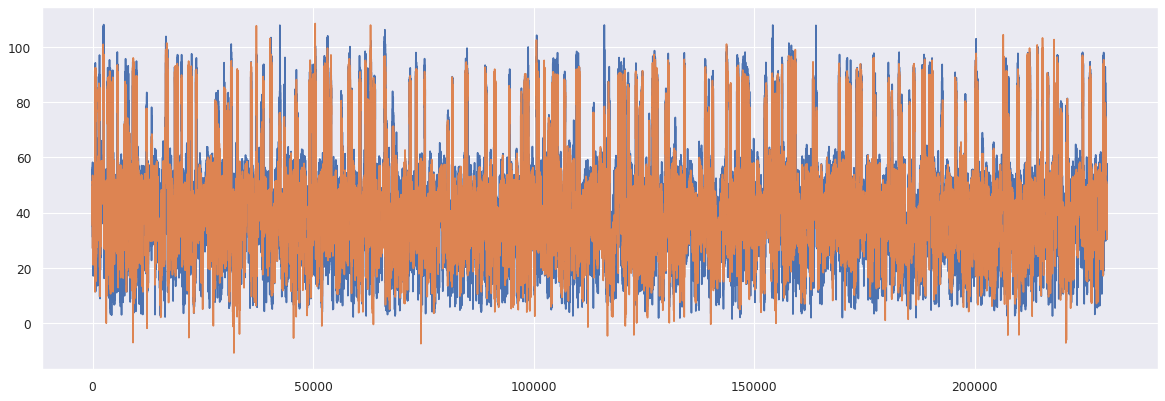

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(18, 6), dpi=80)

plt.plot(dense_test)
plt.plot(mat_hat[pos_test]) 

#### Model 2

Random 40% of data missing

In [ ]:
import numpy as np
np.random.seed(1000)

missing_rate = 0.4

dense_mat = np.load('/content/drive/MyDrive/Traffic speed imputation/Data/Speed/hourly_speed_mat.npy')
binary_mat = dense_mat.copy()
binary_mat[binary_mat != 0] = 1
pos = np.where(np.sum(binary_mat, axis = 1) > 0.7 * binary_mat.shape[1])
dense_mat = dense_mat[pos[0], :]

## Random missing (RM)
random_mat = np.random.rand(dense_mat.shape[0], dense_mat.shape[1])
binary_mat = np.round(random_mat + 0.5 - missing_rate)
sparse_mat = np.multiply(dense_mat, binary_mat)

**Model setting**:

- Low rank: 20
- The number of burn-in iterations: 1000
- The number of Gibbs iterations: 200

In [ ]:
import time
start = time.time()
dim1, dim2 = sparse_mat.shape
rank = 20
init = {"W": 0.01 * np.random.randn(dim1, rank), "X": 0.01 * np.random.randn(dim2, rank)}
burn_iter = 1000
gibbs_iter = 200
mat_hat, W, X, dense_test, pos_test = BPMF(dense_mat, sparse_mat, init, rank, burn_iter, gibbs_iter)
end = time.time()
print('Running time: %d seconds'%(end - start))

Iter: 200
MAPE: 0.110787
RMSE: 5.18546

Iter: 400
MAPE: 0.0968004
RMSE: 4.37223

Iter: 600
MAPE: 0.0967527
RMSE: 4.37052

Iter: 800
MAPE: 0.0966724
RMSE: 4.36587

Iter: 1000
MAPE: 0.096688
RMSE: 4.36905

Imputation MAPE: 0.0967073
Imputation RMSE: 4.36935

Running time: 315 seconds


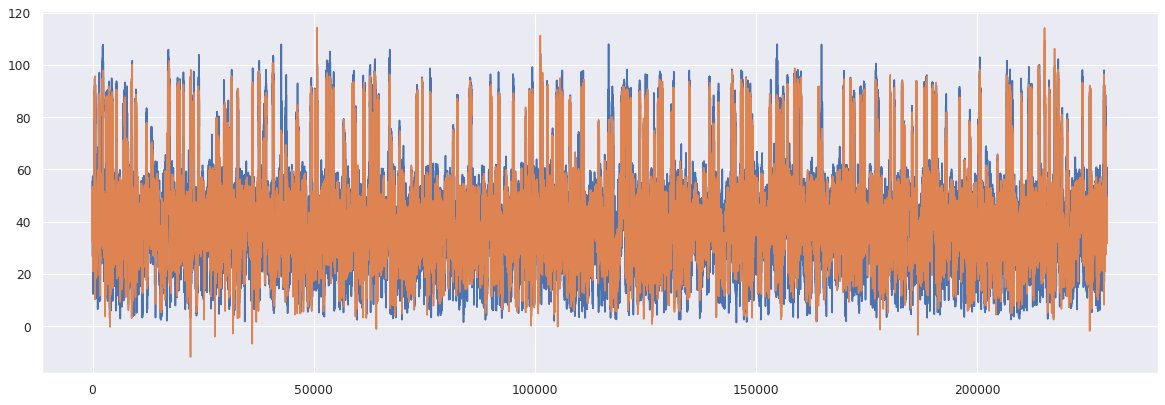

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(18, 6), dpi=80)

plt.plot(dense_test)
plt.plot(mat_hat[pos_test]) 

#### Model 3

Random 60% of data missing

In [ ]:
import numpy as np
np.random.seed(1000)

missing_rate = 0.6

dense_mat = np.load('/content/drive/MyDrive/Traffic speed imputation/Data/Speed/hourly_speed_mat.npy')
binary_mat = dense_mat.copy()
binary_mat[binary_mat != 0] = 1
pos = np.where(np.sum(binary_mat, axis = 1) > 0.7 * binary_mat.shape[1])
dense_mat = dense_mat[pos[0], :]

## Random missing (RM)
random_mat = np.random.rand(dense_mat.shape[0], dense_mat.shape[1])
binary_mat = np.round(random_mat + 0.5 - missing_rate)
sparse_mat = np.multiply(dense_mat, binary_mat)

**Model setting**:

- Low rank: 20
- The number of burn-in iterations: 1000
- The number of Gibbs iterations: 200

In [ ]:
import time
start = time.time()
dim1, dim2 = sparse_mat.shape
rank = 20
init = {"W": 0.01 * np.random.randn(dim1, rank), "X": 0.01 * np.random.randn(dim2, rank)}
burn_iter = 1000
gibbs_iter = 200
mat_hat, W, X, dense_test, pos_test = BPMF(dense_mat, sparse_mat, init, rank, burn_iter, gibbs_iter)
end = time.time()
print('Running time: %d seconds'%(end - start))

Iter: 200
MAPE: 0.139166
RMSE: 6.72236

Iter: 400
MAPE: 0.100549
RMSE: 4.56062

Iter: 600
MAPE: 0.100092
RMSE: 4.53979

Iter: 800
MAPE: 0.100045
RMSE: 4.54137

Iter: 1000
MAPE: 0.100073
RMSE: 4.54135

Imputation MAPE: 0.100096
Imputation RMSE: 4.54115

Running time: 307 seconds


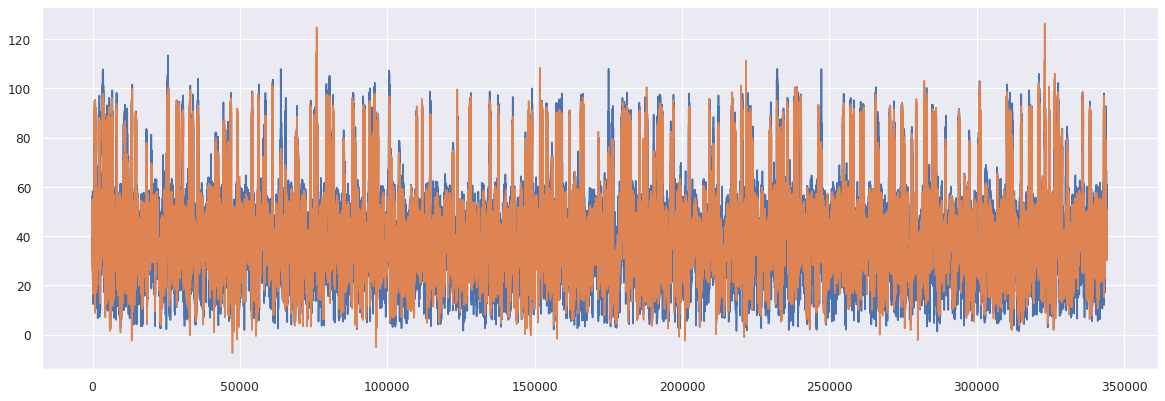

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(18, 6), dpi=80)

plt.plot(dense_test)
plt.plot(mat_hat[pos_test]) 

## Temporal Regularized Matrix Factorization

Source: 

<div class="alert alert-block alert-info">
<font color="black">
Hsiang-Fu Yu, Nikhil Rao, Inderjit S. Dhillon (2016). <b>Temporal regularized matrix factorization for high-dimensional time series prediction</b>. 30th Conference on Neural Information Processing Systems, Barcelona, Spain. <a href="http://www.cs.utexas.edu/~rofuyu/papers/tr-mf-nips.pdf" title="PDF"><b>[PDF]</b></a> 
</font>
</div>

Abstract:

Time series prediction problems are becoming increasingly high-dimensional in
modern applications, such as climatology and demand forecasting. For example,
in the latter problem, the number of items for which demand needs to be forecast
might be as large as 50,000. In addition, the data is generally noisy and full of
missing values. Thus, modern applications require methods that are highly scalable,
and can deal with noisy data in terms of corruptions or missing values. However,
classical time series methods usually fall short of handling these issues. In this
paper, we present a temporal regularized matrix factorization (TRMF) framework
which supports data-driven temporal learning and forecasting. We develop novel
regularization schemes and use scalable matrix factorization methods that are
eminently suited for high-dimensional time series data that has many missing values.
Our proposed TRMF is highly general, and subsumes many existing approaches
for time series analysis. We make interesting connections to graph regularization
methods in the context of learning the dependencies in an autoregressive framework.
Experimental results show the superiority of TRMF in terms of scalability and
prediction quality. In particular, TRMF is two orders of magnitude faster than
other methods on a problem of dimension 50,000, and generates better forecasts on
real-world datasets such as Wal-mart E-commerce datasets.

### TRMF implementation - function

In [ ]:
import numpy as np
from numpy.linalg import inv as inv


def TRMF(dense_mat, sparse_mat, init_para, init_hyper, time_lags, maxiter):    
    ## Initialize parameters
    W = init_para["W"]
    X = init_para["X"]
    theta = init_para["theta"]
    
    ## Set hyperparameters
    lambda_w = init_hyper["lambda_w"]
    lambda_x = init_hyper["lambda_x"]
    lambda_theta = init_hyper["lambda_theta"]
    eta = init_hyper["eta"]
    
    dim1, dim2 = sparse_mat.shape
    pos_train = np.where(sparse_mat != 0)
    pos_test = np.where((dense_mat != 0) & (sparse_mat == 0))
    binary_mat = sparse_mat.copy()
    binary_mat[pos_train] = 1
    d, rank = theta.shape
    
    for it in range(maxiter):
        ## Update spatial matrix W
        for i in range(dim1):
            pos0 = np.where(sparse_mat[i, :] != 0)
            Xt = X[pos0[0], :]
            vec0 = Xt.T @ sparse_mat[i, pos0[0]]
            mat0 = inv(Xt.T @ Xt + lambda_w * np.eye(rank))
            W[i, :] = mat0 @ vec0
        ## Update temporal matrix X
        for t in range(dim2):
            pos0 = np.where(sparse_mat[:, t] != 0)
            Wt = W[pos0[0], :]
            Mt = np.zeros((rank, rank))
            Nt = np.zeros(rank)
            if t < np.max(time_lags):
                Pt = np.zeros((rank, rank))
                Qt = np.zeros(rank)
            else:
                Pt = np.eye(rank)
                Qt = np.einsum('ij, ij -> j', theta, X[t - time_lags, :])
            if t < dim2 - np.min(time_lags):
                if t >= np.max(time_lags) and t < dim2 - np.max(time_lags):
                    index = list(range(0, d))
                else:
                    index = list(np.where((t + time_lags >= np.max(time_lags)) & (t + time_lags < dim2)))[0]
                for k in index:
                    Ak = theta[k, :]
                    Mt += np.diag(Ak ** 2)
                    theta0 = theta.copy()
                    theta0[k, :] = 0
                    Nt += np.multiply(Ak, X[t + time_lags[k], :]
                                      - np.einsum('ij, ij -> j', theta0, X[t + time_lags[k] - time_lags, :]))
            vec0 = Wt.T @ sparse_mat[pos0[0], t] + lambda_x * Nt + lambda_x * Qt
            mat0 = inv(Wt.T @ Wt + lambda_x * Mt + lambda_x * Pt + lambda_x * eta * np.eye(rank))
            X[t, :] = mat0 @ vec0
        
        ## Update AR coefficients theta
        for k in range(d):
            theta0 = theta.copy()
            theta0[k, :] = 0
            mat0 = np.zeros((dim2 - np.max(time_lags), rank))
            for L in range(d):
                mat0 += X[np.max(time_lags) - time_lags[L] : dim2 - time_lags[L] , :] @ np.diag(theta0[L, :])
            VarPi = X[np.max(time_lags) : dim2, :] - mat0
            var1 = np.zeros((rank, rank))
            var2 = np.zeros(rank)
            for t in range(np.max(time_lags), dim2):
                B = X[t - time_lags[k], :]
                var1 += np.diag(np.multiply(B, B))
                var2 += np.diag(B) @ VarPi[t - np.max(time_lags), :]
            theta[k, :] = inv(var1 + lambda_theta * np.eye(rank) / lambda_x) @ var2

        mat_hat = W @ X.T
        mape = np.sum(np.abs(dense_mat[pos_test] - mat_hat[pos_test]) 
                      / dense_mat[pos_test]) / dense_mat[pos_test].shape[0]
        rmse = np.sqrt(np.sum((dense_mat[pos_test] - mat_hat[pos_test]) ** 2)/dense_mat[pos_test].shape[0])
        
        if (it + 1) % 100 == 0:
            print('Iter: {}'.format(it + 1))
            print('Imputation MAPE: {:.6}'.format(mape))
            print('Imputation RMSE: {:.6}'.format(rmse))
            print()
    
    return mat_hat, dense_mat, pos_test

In [ ]:
def compute_rmse(var, var_hat):
    return  np.sqrt(np.sum((var - var_hat) ** 2) / var.shape[0])

### Running on Berlin data

#### Model 1

Random 40% of data missing

In [ ]:
import numpy as np
np.random.seed(1000)

missing_rate = 0.4

dense_mat = np.load('/content/drive/MyDrive/Traffic speed imputation/Data/Speed/hourly_speed_mat.npy')
binary_mat = dense_mat.copy()
binary_mat[binary_mat != 0] = 1
pos = np.where(np.sum(binary_mat, axis = 1) > 0.7 * binary_mat.shape[1])
dense_mat = dense_mat[pos[0], :]

## Non-random missing (NM)
binary_mat = np.zeros(dense_mat.shape)
random_mat = np.random.rand(dense_mat.shape[0], 30)
for i1 in range(dense_mat.shape[0]):
    for i2 in range(30):
        binary_mat[i1, i2 * 24 : (i2 + 1) * 24] = np.round(random_mat[i1, i2] + 0.5 - missing_rate)
sparse_mat = dense_mat * binary_mat

**Model setting**:

- Low rank: 20
- Time lags: {1, 2, 24}
- The number of iterations: 200

In [ ]:
import time
start = time.time()
dim1, dim2 = sparse_mat.shape
rank = 20
time_lags = np.array([1, 2, 24])
d = time_lags.shape[0]
## Initialize parameters
W = 0.1 * np.random.rand(dim1, rank)
X = 0.1 * np.random.rand(dim2, rank)
theta = 0.1 * np.random.rand(d, rank)
init_para = {"W": W, "X": X, "theta": theta}
## Set hyparameters
lambda_w = 500
lambda_x = 500
lambda_theta = 500
eta = 0.03
init_hyper = {"lambda_w": lambda_w, "lambda_x": lambda_x, "lambda_theta": lambda_theta, "eta": eta}
maxiter = 200
mat_hat, dense_mat, pos_test = TRMF(dense_mat, sparse_mat, init_para, init_hyper, time_lags, maxiter)
end = time.time()
print('Running time: %d seconds'%(end - start))

Iter: 100
Imputation MAPE: 0.107352
Imputation RMSE: 4.95714

Iter: 200
Imputation MAPE: 0.107011
Imputation RMSE: 4.94347

Running time: 154 seconds


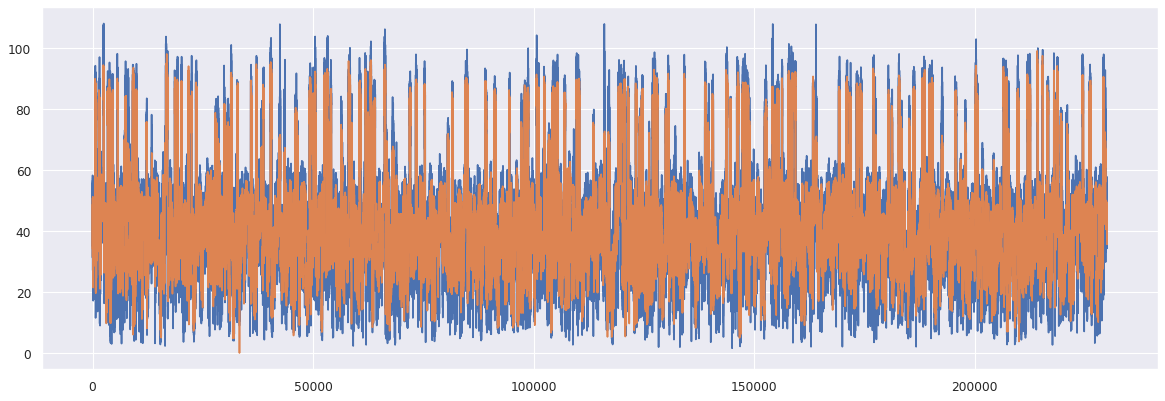

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(18, 6), dpi=80)

plt.plot(dense_mat[pos_test])
plt.plot(mat_hat[pos_test]) 

#### Model 2

Random 40% of data missing

In [ ]:
import numpy as np
np.random.seed(1000)

missing_rate = 0.4

dense_mat = np.load('/content/drive/MyDrive/Traffic speed imputation/Data/Speed/hourly_speed_mat.npy')
binary_mat = dense_mat.copy()
binary_mat[binary_mat != 0] = 1
pos = np.where(np.sum(binary_mat, axis = 1) > 0.7 * binary_mat.shape[1])
dense_mat = dense_mat[pos[0], :]

## Random missing (RM)
random_mat = np.random.rand(dense_mat.shape[0], dense_mat.shape[1])
binary_mat = np.round(random_mat + 0.5 - missing_rate)
sparse_mat = dense_mat * binary_mat

**Model setting**:

- Low rank: 20
- Time lags: {1, 2, 24}
- The number of iterations: 200

In [ ]:
import time
start = time.time()
dim1, dim2 = sparse_mat.shape
rank = 20
time_lags = np.array([1, 2, 24])
d = time_lags.shape[0]
## Initialize parameters
W = 0.1 * np.random.rand(dim1, rank)
X = 0.1 * np.random.rand(dim2, rank)
theta = 0.1 * np.random.rand(d, rank)
init_para = {"W": W, "X": X, "theta": theta}
## Set hyparameters
lambda_w = 500
lambda_x = 500
lambda_theta = 500
eta = 0.03
init_hyper = {"lambda_w": lambda_w, "lambda_x": lambda_x, "lambda_theta": lambda_theta, "eta": eta}
maxiter = 200
mat_hat, dense_mat, pos_test = TRMF(dense_mat, sparse_mat, init_para, init_hyper, time_lags, maxiter)
end = time.time()
print('Running time: %d seconds'%(end - start))

Iter: 100
Imputation MAPE: 0.102691
Imputation RMSE: 4.75441

Iter: 200
Imputation MAPE: 0.102315
Imputation RMSE: 4.74077

Running time: 152 seconds


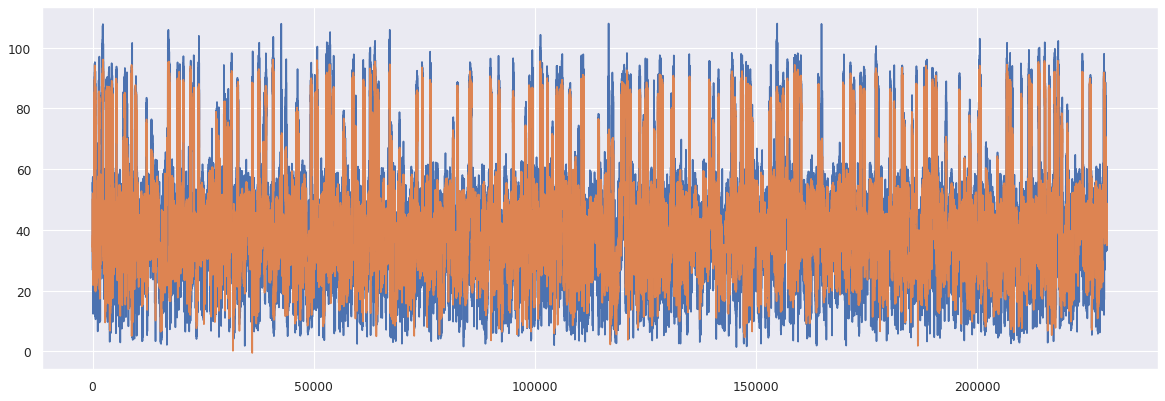

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(18, 6), dpi=80)

plt.plot(dense_mat[pos_test])
plt.plot(mat_hat[pos_test]) 

#### Model 3

Random 60% of data missing

In [ ]:
import numpy as np
np.random.seed(1000)

missing_rate = 0.6

dense_mat = np.load('/content/drive/MyDrive/Traffic speed imputation/Data/Speed/hourly_speed_mat.npy')
binary_mat = dense_mat.copy()
binary_mat[binary_mat != 0] = 1
pos = np.where(np.sum(binary_mat, axis = 1) > 0.7 * binary_mat.shape[1])
dense_mat = dense_mat[pos[0], :]

## Random missing (RM)
random_mat = np.random.rand(dense_mat.shape[0], dense_mat.shape[1])
binary_mat = np.round(random_mat + 0.5 - missing_rate)
sparse_mat = dense_mat * binary_mat

**Model setting**:

- Low rank: 20
- Time lags: {1, 2, 24}
- The number of iterations: 200

In [ ]:
import time
start = time.time()
dim1, dim2 = sparse_mat.shape
rank = 20
time_lags = np.array([1, 2, 24])
d = time_lags.shape[0]
## Initialize parameters
W = 0.1 * np.random.rand(dim1, rank)
X = 0.1 * np.random.rand(dim2, rank)
theta = 0.1 * np.random.rand(d, rank)
init_para = {"W": W, "X": X, "theta": theta}
## Set hyparameters
lambda_w = 500
lambda_x = 500
lambda_theta = 500
eta = 0.03
init_hyper = {"lambda_w": lambda_w, "lambda_x": lambda_x, "lambda_theta": lambda_theta, "eta": eta}
maxiter = 200
mat_hat, dense_mat, pos_test = TRMF(dense_mat, sparse_mat, init_para, init_hyper, time_lags, maxiter)
end = time.time()
print('Running time: %d seconds'%(end - start))

Iter: 100
Imputation MAPE: 0.107671
Imputation RMSE: 4.99331

Iter: 200
Imputation MAPE: 0.106952
Imputation RMSE: 4.96259

Running time: 146 seconds


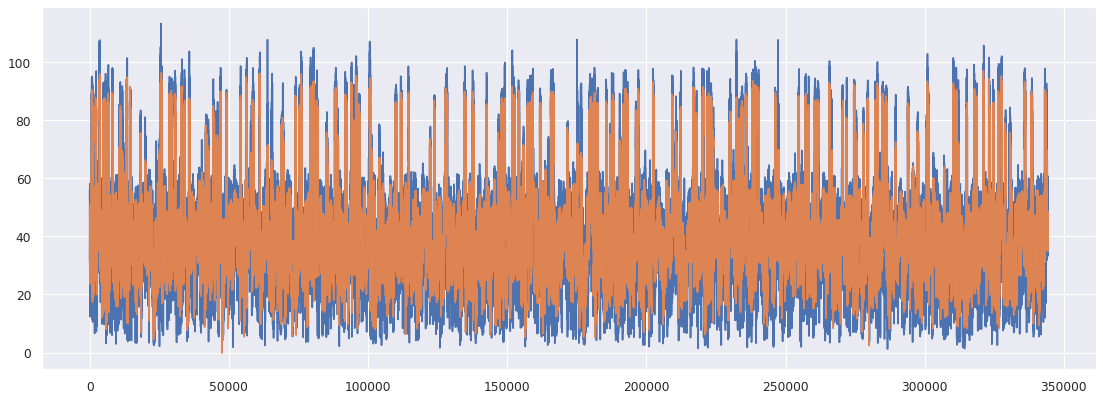

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(17, 6), dpi=80)

plt.plot(dense_mat[pos_test])
plt.plot(mat_hat[pos_test]) 